In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable. Removed the max price on luxury vehicles.  Dropped non-luxury maximum to 250k.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0,1233416.0
mean,22640.0,0.0,69655.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22367.0,1.0,66701.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8430.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18555.0,0.0,54832.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32408.0,0.0,113158.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 8.0
Last section took: 8.0
(in seconds)


In [5]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233416 entries, 0 to 1233415
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1233416 non-null  object 
 1   price                  1233416 non-null  float64
 2   odometer_type          1233416 non-null  int64  
 3   mileage                1233416 non-null  int64  
 4   county                 1233416 non-null  object 
 5   zip                    1233416 non-null  object 
 6   model_year             1233416 non-null  int64  
 7   make                   1233416 non-null  object 
 8   model                  1233416 non-null  object 
 9   vehicle_type           1233416 non-null  object 
 10  new_used               1233416 non-null  object 
 11  title_issue_date       1233416 non-null  object 
 12  purchase_date          1233416 non-null  object 
 13  age                    1233416 non-null  int64  
 14  make_cat_popular  

In [6]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

Text(0, 0.5, 'Number of Registration Transactions')

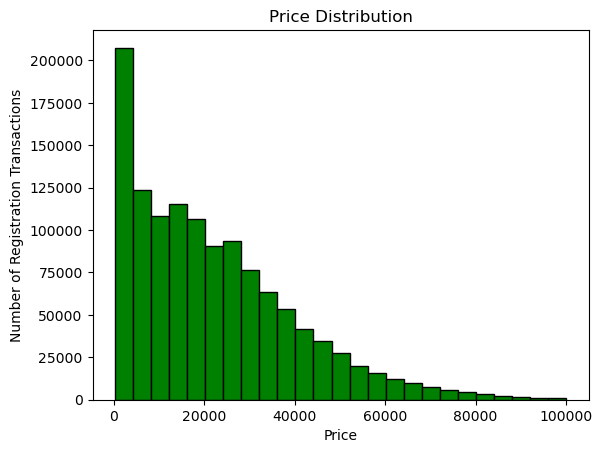

In [7]:
#plot the distribution of the price values

temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]<100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")

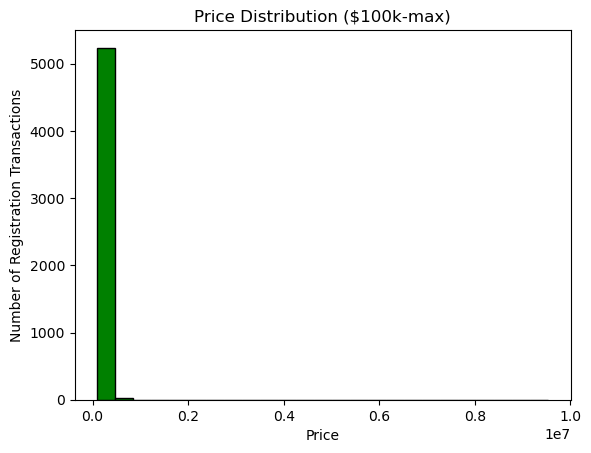

Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.


In [8]:
#plot the distribution of the price values
temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]>=100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution ($100k-max)")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")
plt.show()
print("Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.")

            price  mileage   age  new_used_U  new_used_N  type_AUTO  \
price        1.00    -0.52 -0.52       -0.43        0.43      -0.19   
mileage     -0.52     1.00  0.69        0.50       -0.50      -0.03   
age         -0.52     0.69  1.00        0.49       -0.49       0.01   
new_used_U  -0.43     0.50  0.49        1.00       -1.00       0.05   
new_used_N   0.43    -0.50 -0.49       -1.00        1.00      -0.05   
type_AUTO   -0.19    -0.03  0.01        0.05       -0.05       1.00   
type_TRUCK   0.19     0.03 -0.01       -0.05        0.05      -1.00   

            type_TRUCK  
price             0.19  
mileage           0.03  
age              -0.01  
new_used_U       -0.05  
new_used_N        0.05  
type_AUTO        -1.00  
type_TRUCK        1.00  


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

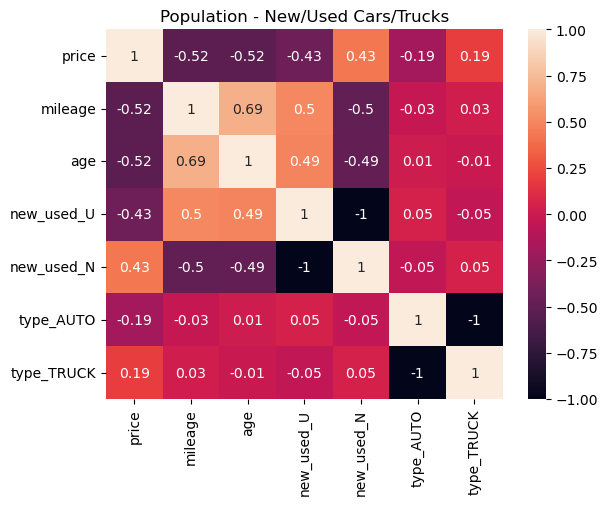

In [9]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price","mileage","age",'new_used_U','new_used_N',"type_AUTO","type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)

                       price  make_cat_popular  make_cat_imports  \
price                   1.00             -0.05             -0.04   
make_cat_popular       -0.05              1.00             -0.57   
make_cat_imports       -0.04             -0.57              1.00   
make_cat_sports         0.10             -0.46             -0.05   
make_cat_luxury         0.08             -0.37             -0.04   
make_cat_discontinued  -0.06             -0.38             -0.04   
make_cat_other          0.04             -0.23             -0.03   

                       make_cat_sports  make_cat_luxury  \
price                             0.10             0.08   
make_cat_popular                 -0.46            -0.37   
make_cat_imports                 -0.05            -0.04   
make_cat_sports                   1.00            -0.03   
make_cat_luxury                  -0.03             1.00   
make_cat_discontinued            -0.03            -0.03   
make_cat_other                   -0.02    

<AxesSubplot: title={'center': 'Population - Make Categories'}>

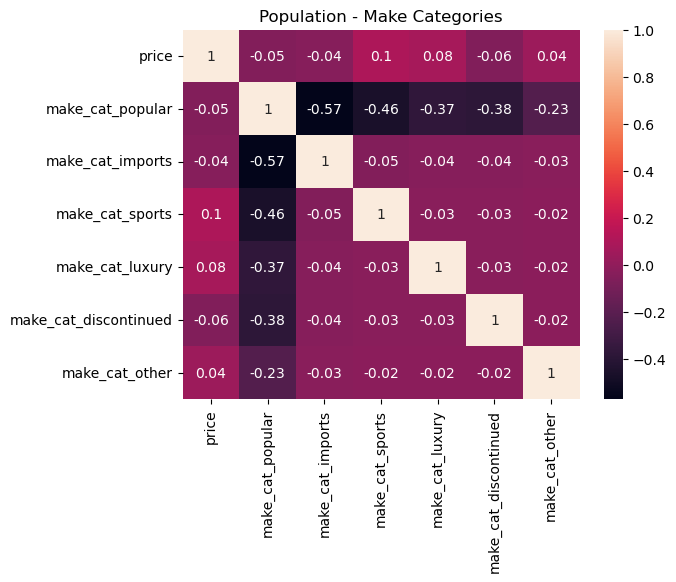

In [10]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price",'make_cat_popular','make_cat_imports','make_cat_sports',
                                  "make_cat_luxury","make_cat_discontinued","make_cat_other"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - Make Categories")
sns.heatmap(tn_auto_reg_f_hm, annot=True)


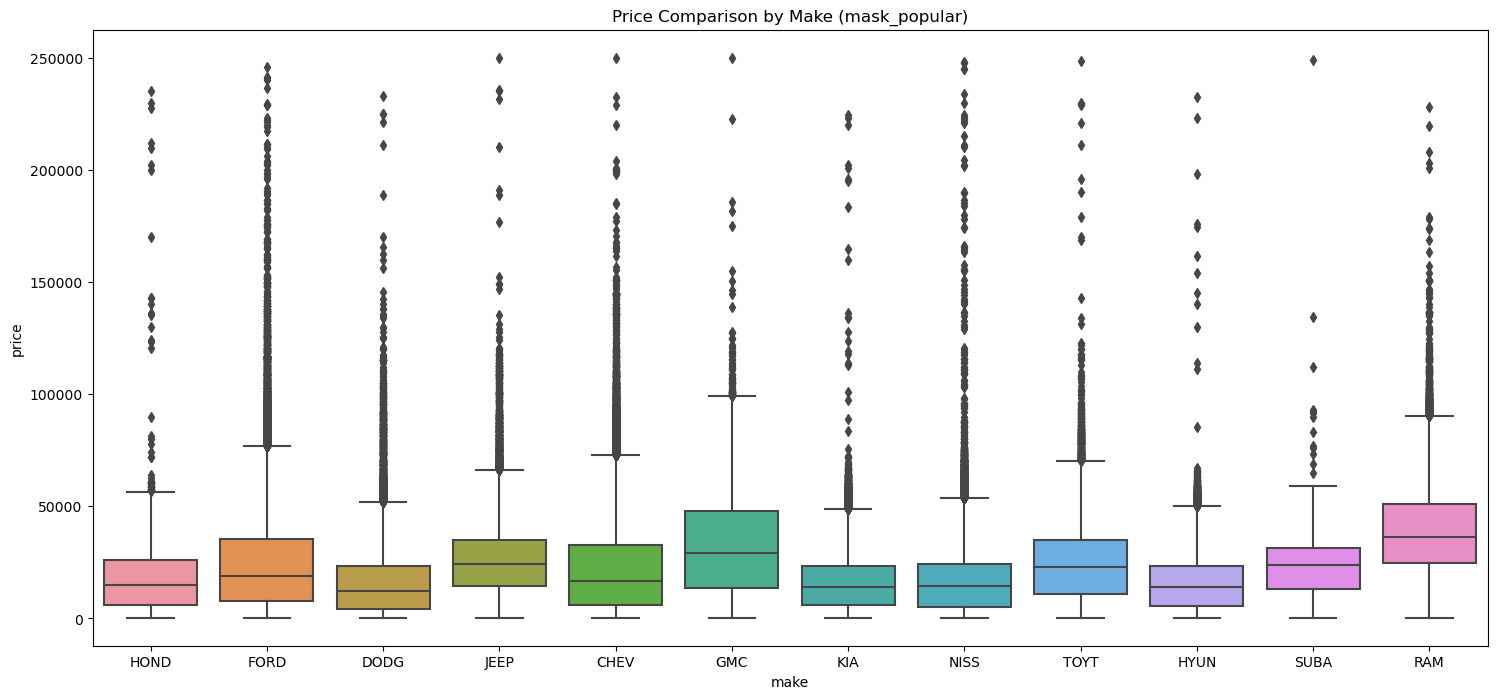

In [11]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_popular])
plt.title("Price Comparison by Make (mask_popular)")
plt.show()

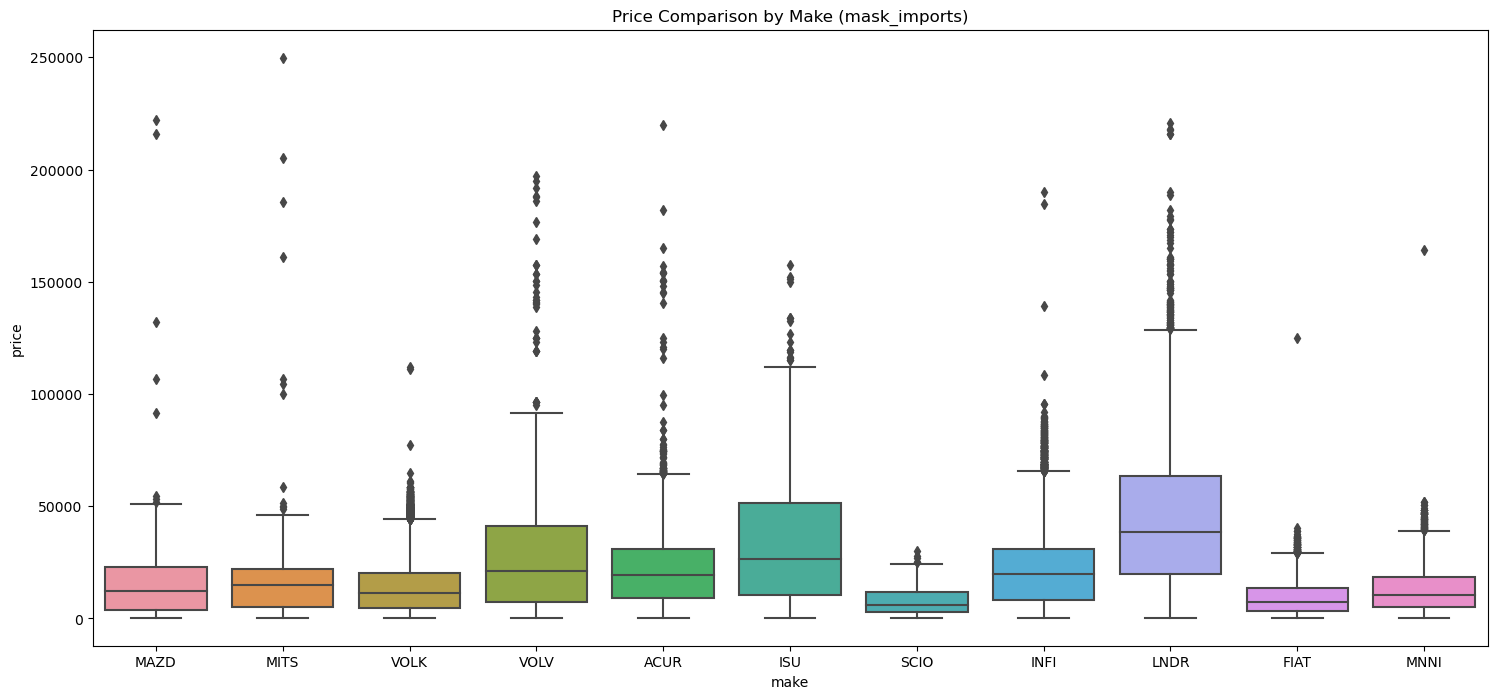

In [12]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_imports])
plt.title("Price Comparison by Make (mask_imports)")
plt.show()

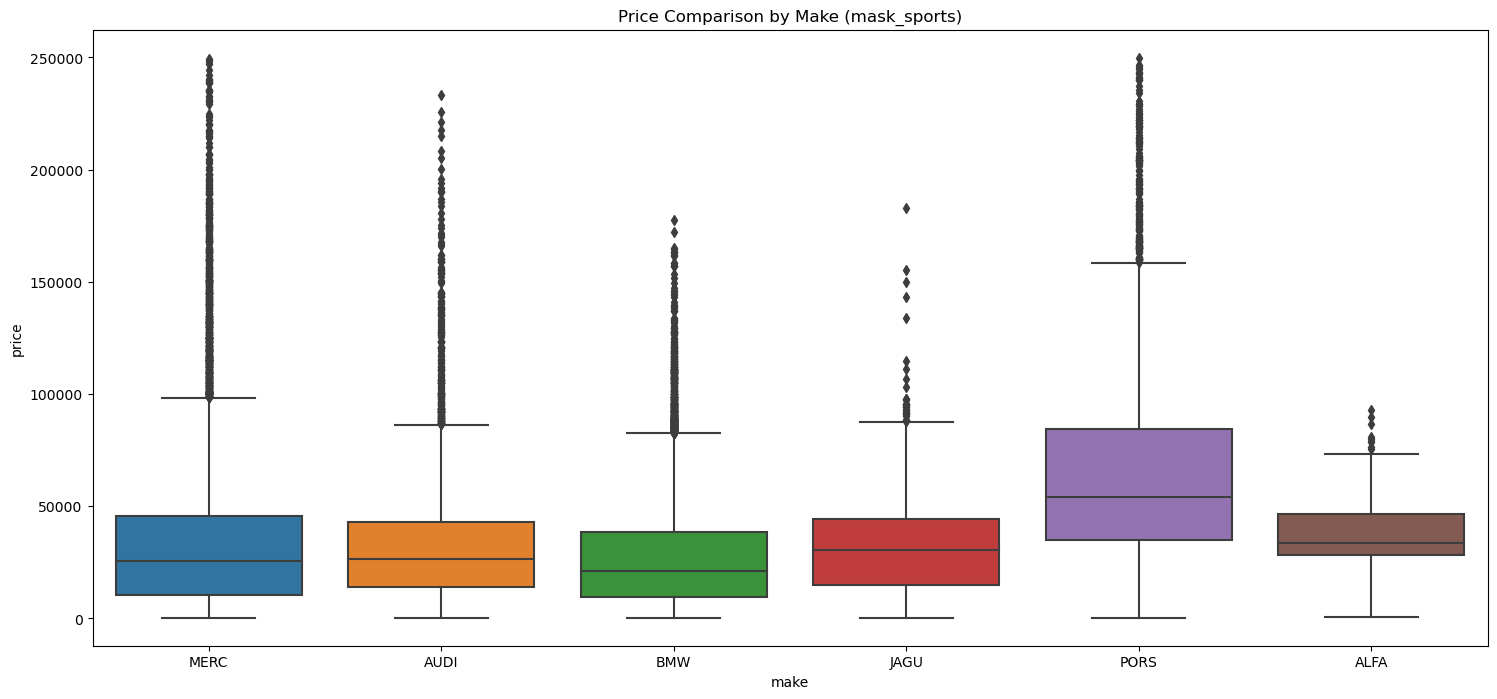

In [13]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_sports])
plt.title("Price Comparison by Make (mask_sports)")
plt.show()

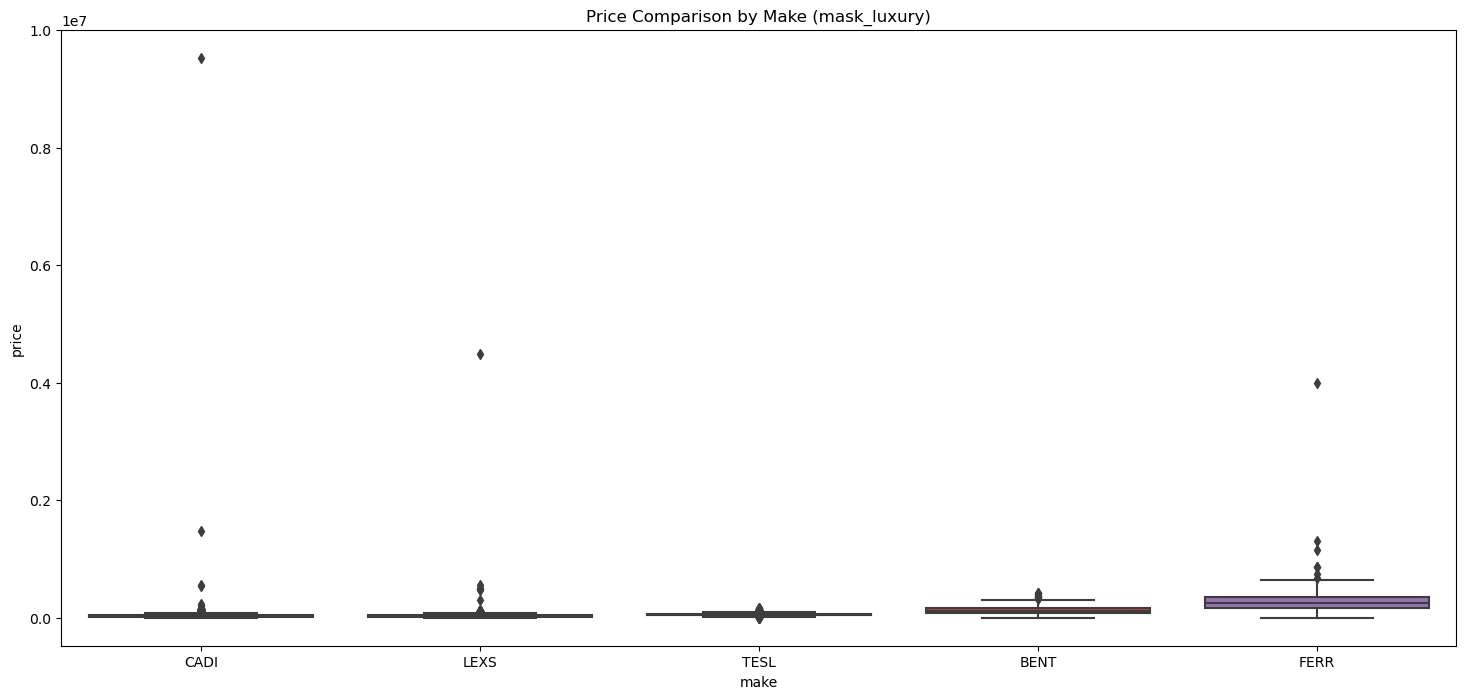

In [14]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_luxury])
plt.title("Price Comparison by Make (mask_luxury)")
plt.show()

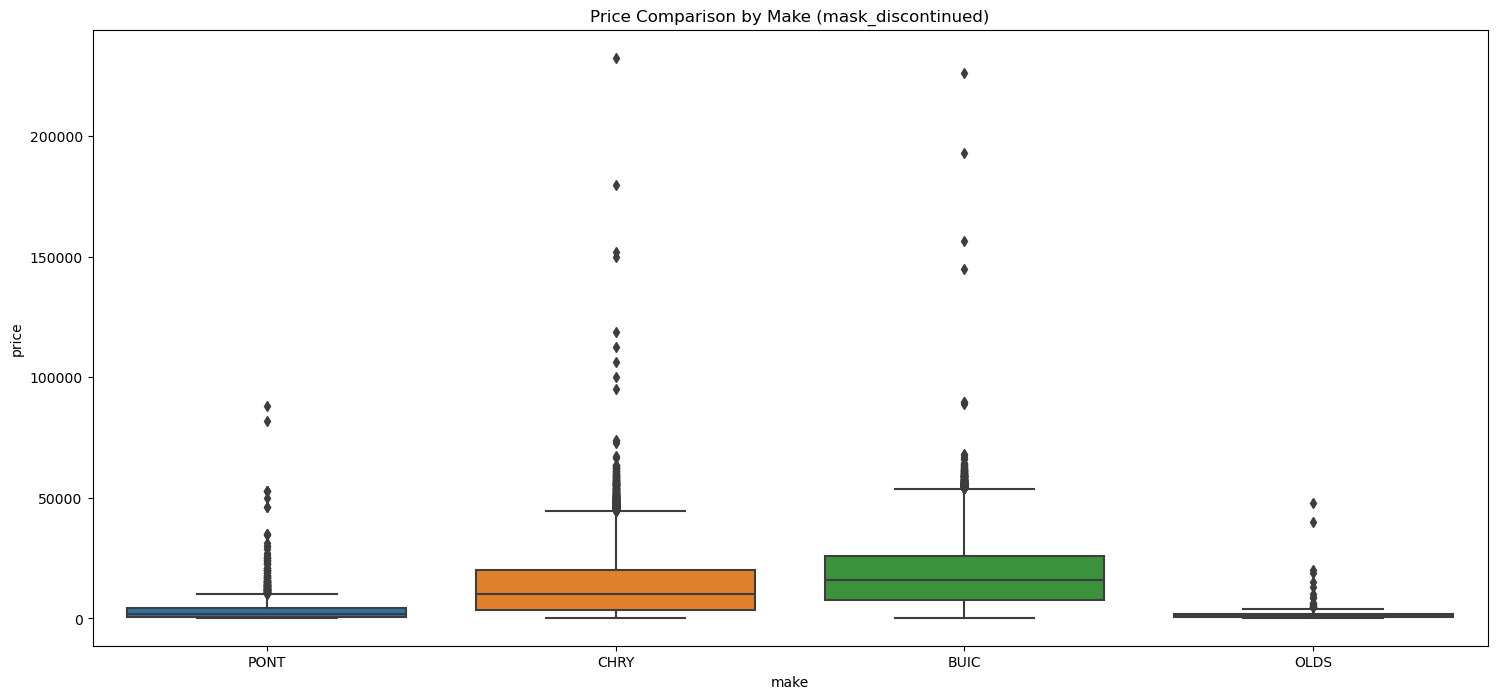

In [15]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_discontinued])
plt.title("Price Comparison by Make (mask_discontinued)")
plt.show()

Number of results: 13225


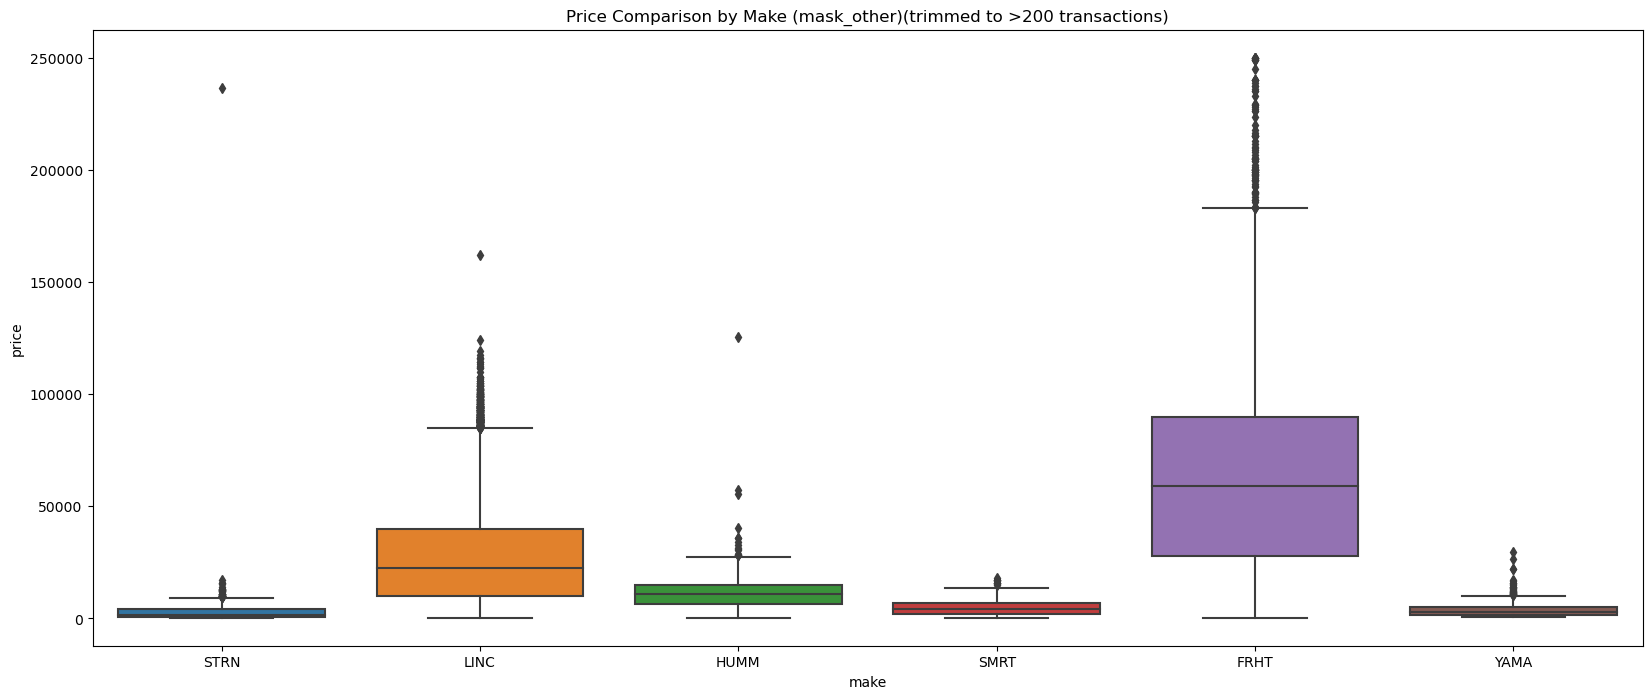

In [16]:
#trimming this down to significant data points (more than 200 transactions)
make_counts = tn_auto_reg_f['make'].value_counts()
mask_make_counts = tn_auto_reg_f['make'].isin(make_counts[make_counts > 200].index)

#boxplot like all the other masks above
plt.figure(figsize=(20,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_other & mask_make_counts])
print("Number of results: " + str(len(tn_auto_reg_f[mask_other & mask_make_counts])))
plt.title("Price Comparison by Make (mask_other)(trimmed to >200 transactions)")
plt.show()

In [17]:
print("Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot")
tn_auto_reg_f[mask_other]['make'].value_counts()

Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot


LINC    8457
FRHT    2305
STRN    1010
SMRT     566
YAMA     481
HUMM     406
Name: make, dtype: int64

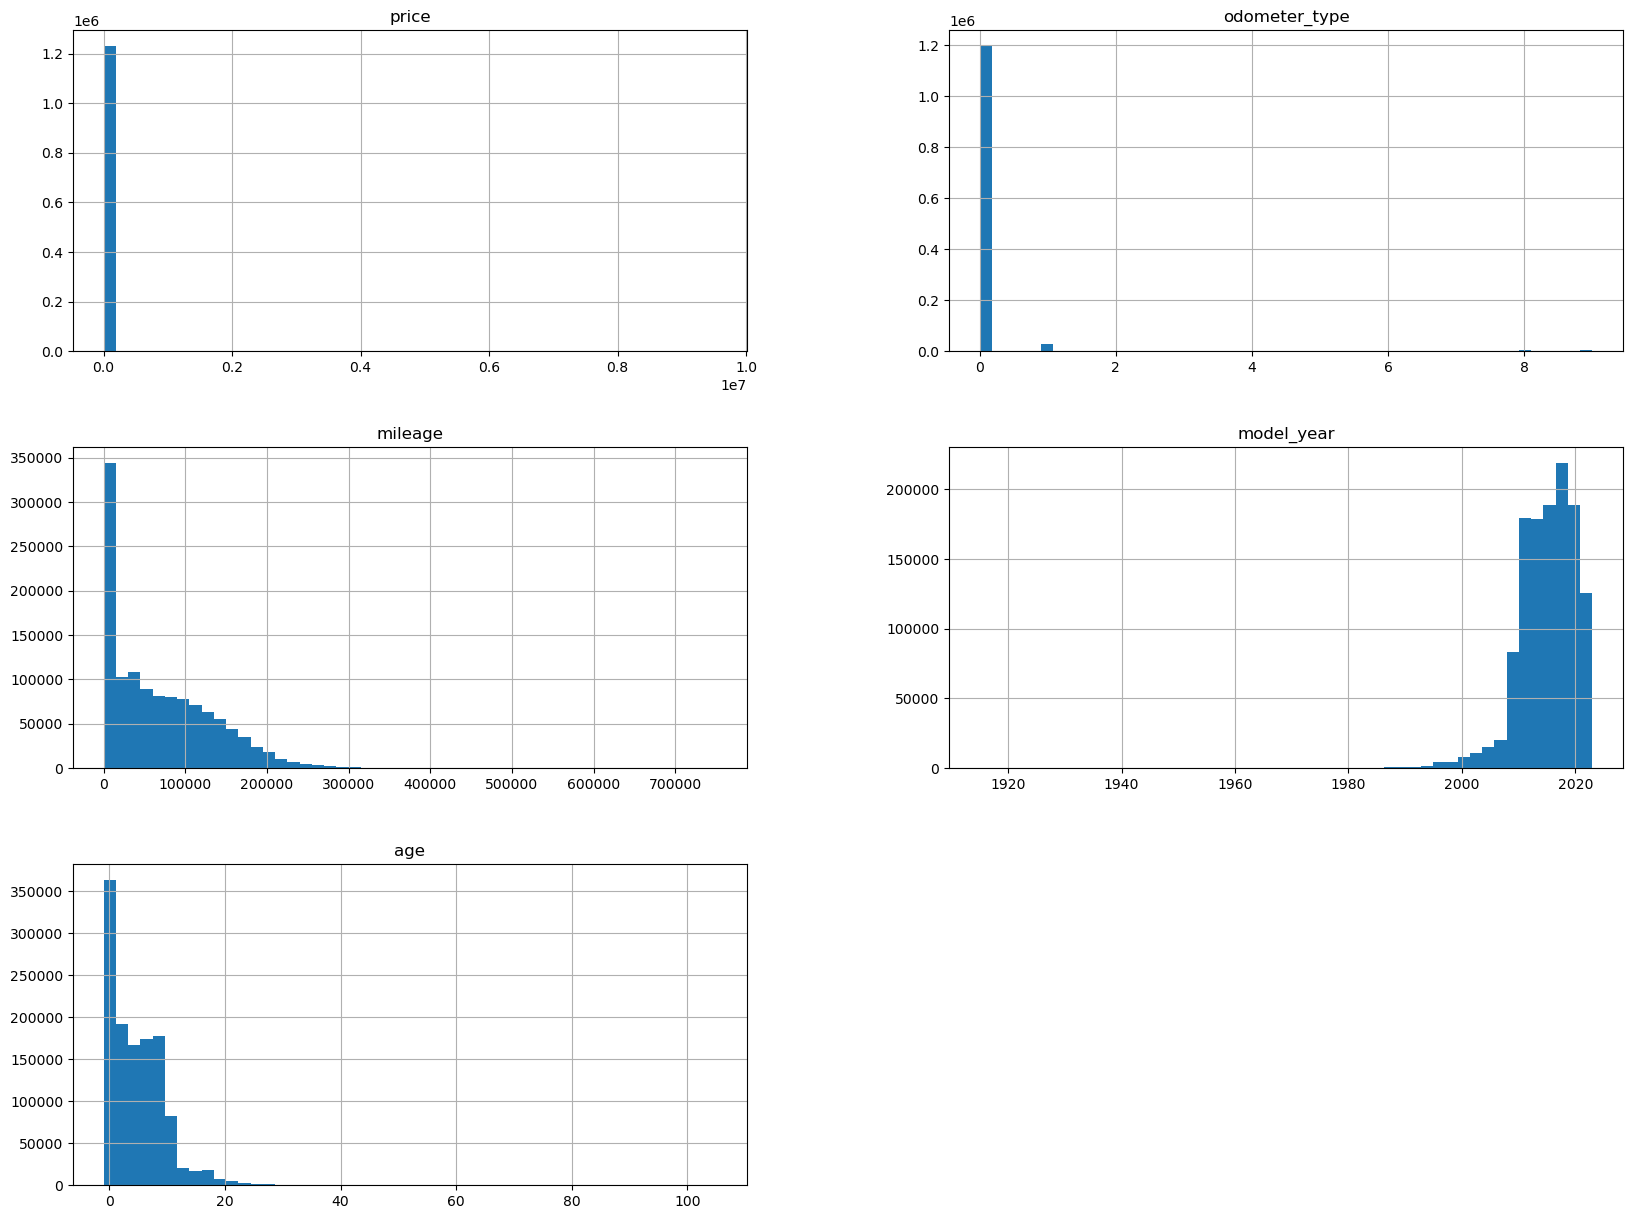

Price, mileage, and age are confirmed by corr analysis to be strong indicators.
Striving for a normal distribution will take some work


In [18]:
tn_auto_reg_f[["price","odometer_type","mileage","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()
print("Price, mileage, and age are confirmed by corr analysis to be strong indicators.")
print("Striving for a normal distribution will take some work")

In [65]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])


Log(age) didn't compute and model year didn't look any different.  Left them alone

Showing transformations on right side that will be prefered in ML algorithm


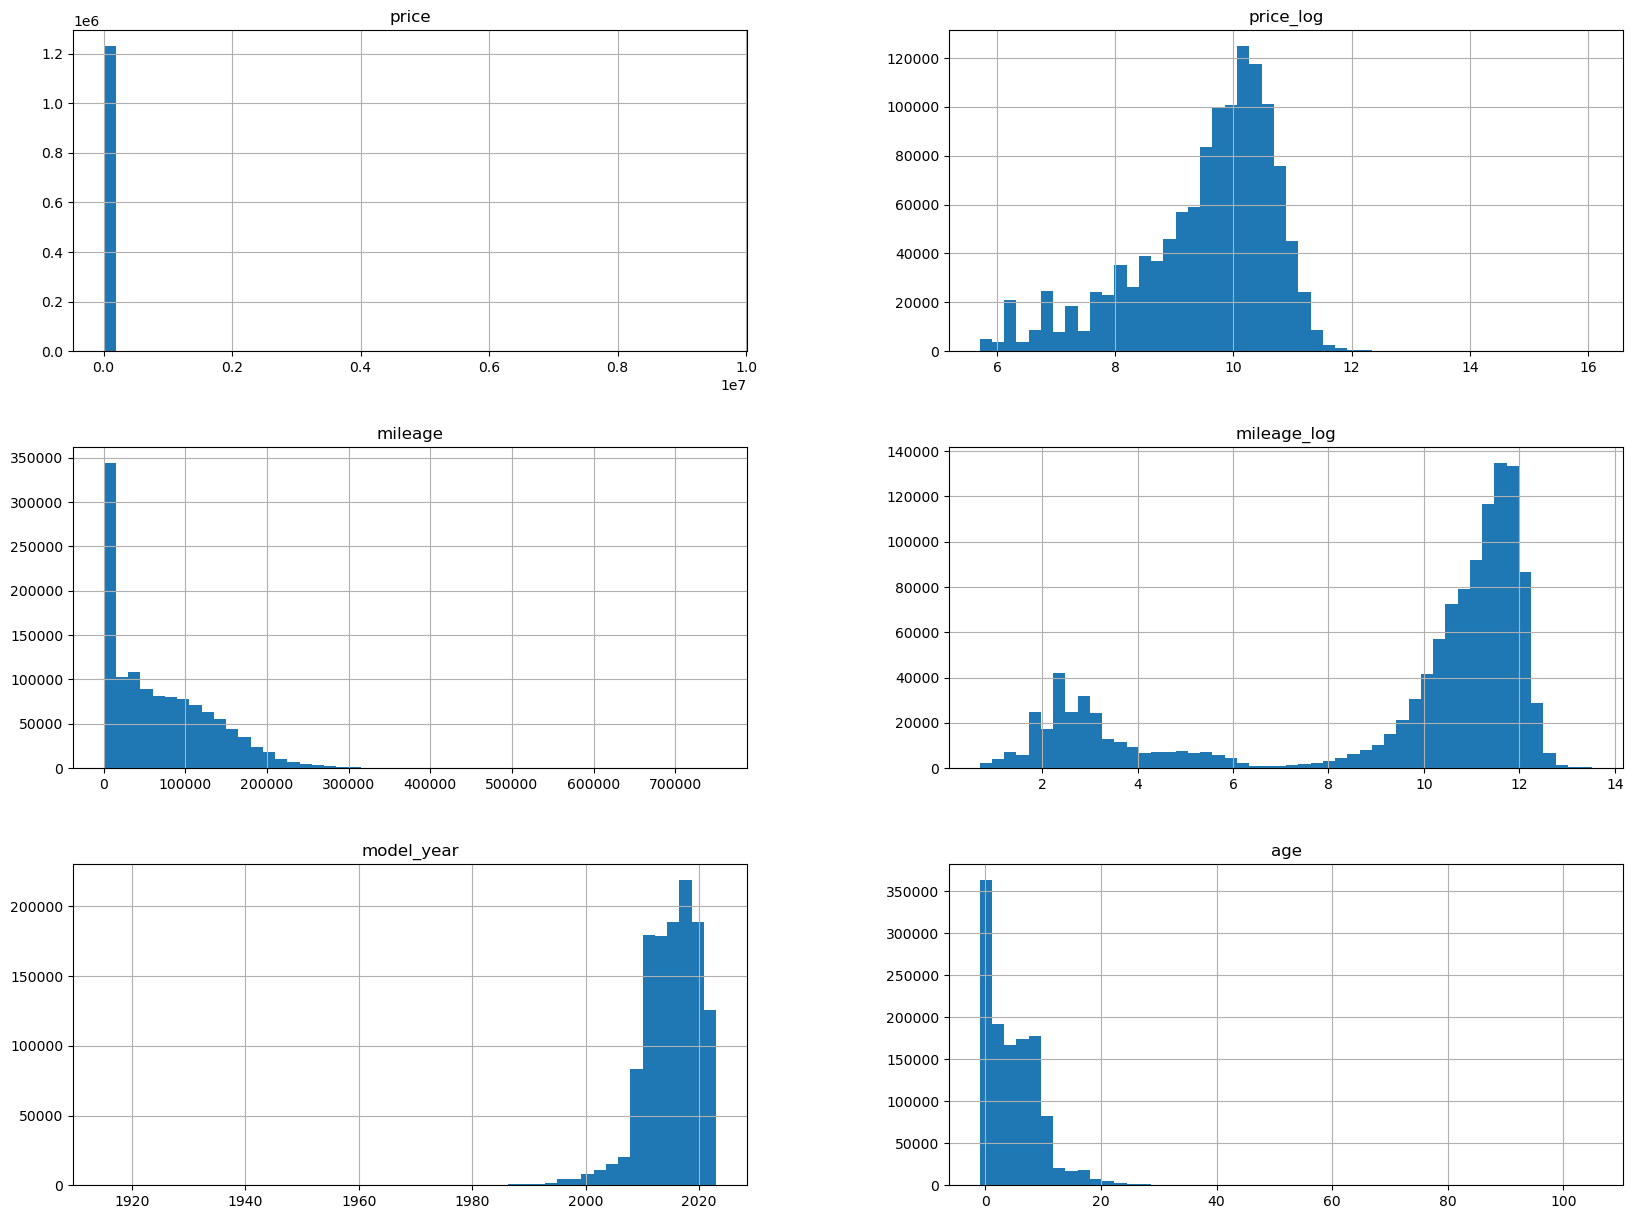

In [66]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [22]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model         1         0
270   AUDI   WA1   71801.0   61369.0
497    BMW    M5  124811.0   55043.0
1118  CHEV   CIL   39640.0   29896.0
3970  HYUN    SA   34380.0   11650.0
2633  FORD   MAC   57001.0   59264.0
4703   KIA   STI   41447.0   33522.0
6817  TOYT   5TF   32000.0   26501.0
7480  VOLV   S80   10000.0    7511.0
4612   KIA   K5G   32284.0   32172.0
3399   GMC   SIE   58672.0   22119.0
3171  FRHT   XCM  200375.0  239995.0
473    BMW   G31    5365.0    1810.0
7581  YAMA   MH3    4940.0    2546.0
5247  MERC    4D   54144.0   51092.0
6472   RAM   RAM   60176.0   28941.0
6752  TESL   MO3   63290.0   36000.0
2902  FORD   W2B   69681.0   60089.0
4289  JAGU    XE   78114.0   26463.0
3448   GMC   TK3   68763.0     750.0
4902  LINC   J2D   51163.0   53855.0
Seeing some models go up on average.


C:\Users\bobbs\AppData\Local\Temp\ipykernel_4752\3464386721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['New', 'Used'])


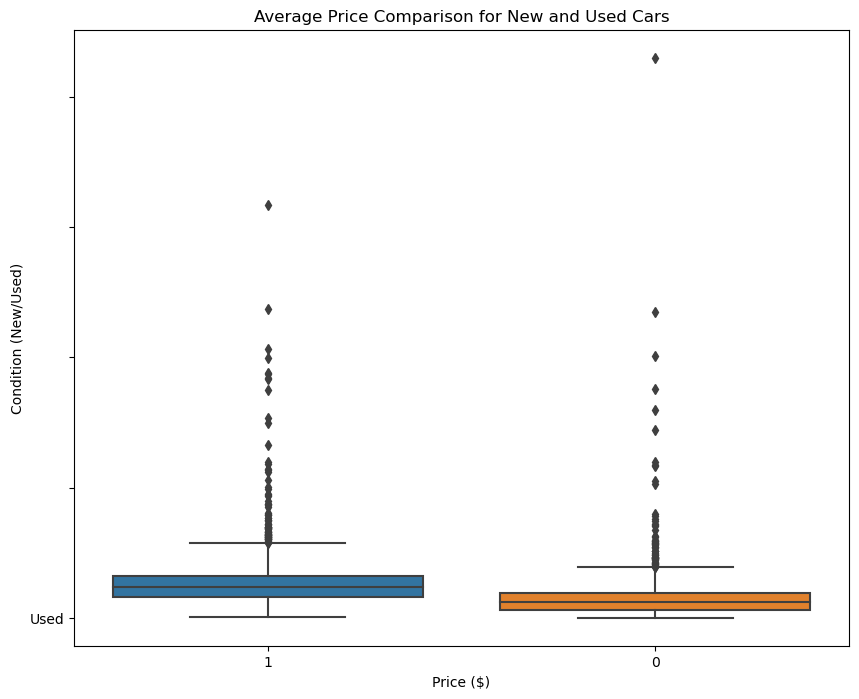

In [23]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,8))

# Plot boxplots for new and used cars side by side
sns.boxplot(data=avg_price_filtered[[1, 0]],  ax=ax)

# Set title and axis labels
ax.set_title("Average Price Comparison for New and Used Cars")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Condition (New/Used)")
ax.set_yticklabels(['New', 'Used'])

# Show plot
plt.show()

In [24]:

# Sort by VIN
sorted = tn_auto_reg_f.sort_values(by=['vin','age'])

# Count the number of records per VIN 
vin_counts = sorted['vin'].value_counts()

# Exclude any cars with less than 5 records
multiple_vins = vin_counts[vin_counts > 1].index

sorted = sorted[sorted['vin'].isin(multiple_vins)] #refactor here? j
print("Number of VINs with more than 1 records:", len(multiple_vins))

known_new_VINs = tn_auto_reg_f[tn_auto_reg_f['new_used_N']==1]['vin'].unique()
print("Number of new VINs:", len(known_new_VINs))

sorted_and_new = sorted[sorted['vin'].isin(known_new_VINs)]
print("Number of VINs that have new and used registrations:", len(sorted_and_new))

sorted_and_new.describe()

Number of VINs with more than 1 records: 93795
Number of new VINs: 226504
Number of VINs that have new and used registrations: 2903


,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U,price_log,mileage_log
count,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.0,2903.0,2903.000000,2903.000000
mean,46101.534368,0.022046,63.541853,2020.115398,-0.049604,0.887013,0.042370,0.021357,0.022735,0.013779,0.012745,0.704788,0.295212,1.0,0.0,10.647048,3.274824
std,21470.061943,0.202150,98.841021,1.519270,0.482233,0.316631,0.201466,0.144597,0.149083,0.116592,0.112193,0.456217,0.456217,0.0,0.0,0.439469,1.295314
min,580.000000,0.000000,1.000000,2015.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,6.364751,0.693147
25%,31735.000000,0.000000,10.000000,2019.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,10.365207,2.397895
50%,42512.000000,0.000000,19.000000,2020.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,10.657565,2.995732
75%,55205.500000,0.000000,67.000000,2021.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.0,10.918836,4.219508
max,330199.000000,8.000000,500.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.0,12.707454,6.216606


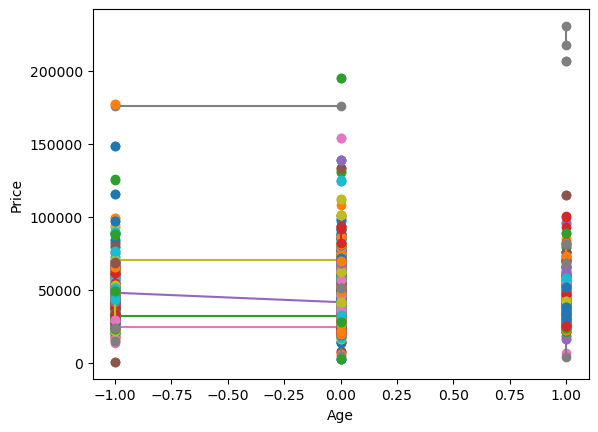

In [25]:
#For the last 2 plots, you can try a 3d graph finding an order for the VINs that makes sense (for example category or make). 
#You can also create a new feature tagging the cars whose price increased and check if there are predictors for that 
#(correlation table). Then, use one of these predictors to order the VINs along the 3rd axis of the plot.

# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots()

current_vin = None
current_x = None
current_y = None

for index, row in sorted_and_new.iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Price')
plt.show()

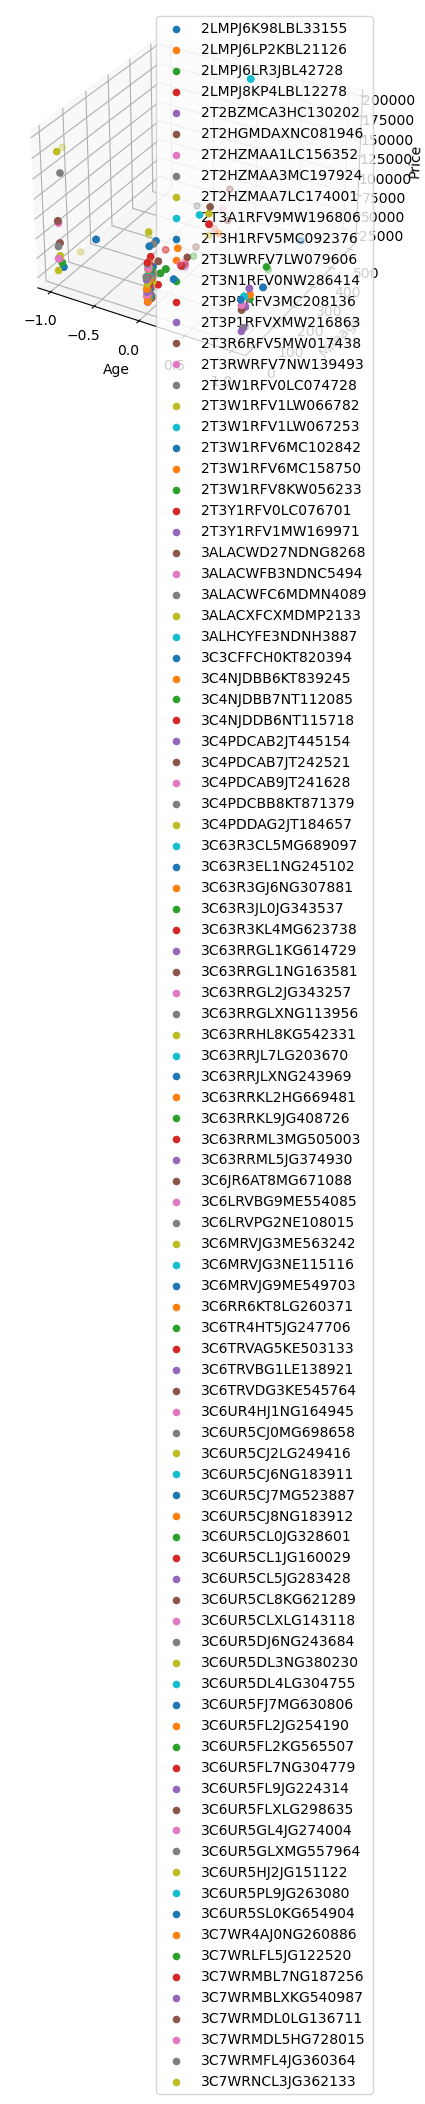

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Slice the middle 200 entries
start_idx = (len(sorted_and_new) - 200) // 2
end_idx = start_idx + 200
sorted_and_new = sorted_and_new.iloc[start_idx:end_idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize variables for storing data for each VIN
current_vin = None
current_x = None
current_y = None
current_z = None

for index, row in sorted_and_new.iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None and current_z is not None:
            ax.scatter(current_x, current_y, current_z, marker='o', label=current_vin)
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['mileage']]
        current_z = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['mileage'])
        current_z.append(row['price'])

# Add legend and axis labels
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Mileage')
ax.set_zlabel('Price')
plt.show()

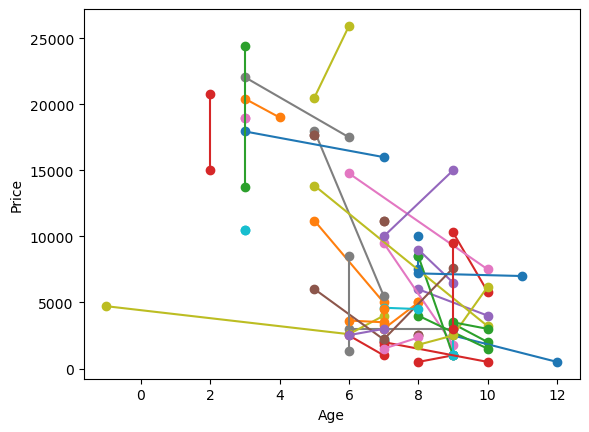

In [27]:
# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots()

current_vin = None
current_x = None
current_y = None

for index, row in sorted.iloc[100:200].iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Price')
plt.show()

Most vehicles decrease in value after converting to new, but a few increase in value. Believe it makes sense that a dealership may value a trade-in at a lower price than when it is resold on their lot. 

Below begins the 3rd stage gate 


In [28]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Analysis completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Analysis completed (total time): 45.0
This section took: 37.0
(in seconds)


Below is the code for the final stagegate of this term project. 

In [29]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233416 entries, 0 to 1233415
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1233416 non-null  object 
 1   price                  1233416 non-null  float64
 2   odometer_type          1233416 non-null  int64  
 3   mileage                1233416 non-null  int64  
 4   county                 1233416 non-null  object 
 5   zip                    1233416 non-null  object 
 6   model_year             1233416 non-null  int64  
 7   make                   1233416 non-null  object 
 8   model                  1233416 non-null  object 
 9   vehicle_type           1233416 non-null  object 
 10  new_used               1233416 non-null  object 
 11  title_issue_date       1233416 non-null  object 
 12  purchase_date          1233416 non-null  object 
 13  age                    1233416 non-null  int64  
 14  make_cat_popular  

In [30]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
dropped = dropped.drop("make", axis=1)
dropped = dropped.drop("model", axis=1)
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)

dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233416 entries, 0 to 1233415
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   age                    1233416 non-null  int64  
 1   make_cat_popular       1233416 non-null  int64  
 2   make_cat_imports       1233416 non-null  int64  
 3   make_cat_sports        1233416 non-null  int64  
 4   make_cat_luxury        1233416 non-null  int64  
 5   make_cat_discontinued  1233416 non-null  int64  
 6   make_cat_other         1233416 non-null  int64  
 7   type_AUTO              1233416 non-null  int64  
 8   type_TRUCK             1233416 non-null  int64  
 9   new_used_N             1233416 non-null  int64  
 10  new_used_U             1233416 non-null  int64  
 11  price_log              1233416 non-null  float64
 12  mileage_log            1233416 non-null  float64
dtypes: float64(2), int64(11)
memory usage:

In [31]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)

train_set, test_set = train_test_split(dropped, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
11.132587,0.0,NaN,NaN
9.749520,0.0,0.0,-0.0
10.582361,0.0,NaN,NaN
10.409135,0.0,NaN,NaN
10.737222,0.0,0.0,-0.0
9.493037,0.0,NaN,NaN
11.306086,0.0,NaN,NaN
9.568024,0.0,0.0,-0.0
10.288485,0.0,NaN,NaN
10.943835,0.0,NaN,NaN


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [33]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [34]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [35]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986732 entries, 1227977 to 121958
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age                    986732 non-null  int64  
 1   make_cat_popular       986732 non-null  int64  
 2   make_cat_imports       986732 non-null  int64  
 3   make_cat_sports        986732 non-null  int64  
 4   make_cat_luxury        986732 non-null  int64  
 5   make_cat_discontinued  986732 non-null  int64  
 6   make_cat_other         986732 non-null  int64  
 7   type_AUTO              986732 non-null  int64  
 8   type_TRUCK             986732 non-null  int64  
 9   new_used_N             986732 non-null  int64  
 10  new_used_U             986732 non-null  int64  
 11  mileage_log            986732 non-null  float64
dtypes: float64(1), int64(11)
memory usage: 97.9 MB
None


<class 'pandas.core.series.Series'>
Int64Index: 986732 entries, 1227977 to 121958


In [36]:
from sklearn.compose import ColumnTransformer

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","new_used_U","make_cat_popular","make_cat_imports","make_cat_sports","make_cat_luxury",
               "make_cat_discontinued","make_cat_other", "type_AUTO", "type_TRUCK"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [37]:
registrations_prepared

array([[-1.09177527, -1.00824919,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59453611,  1.01680722,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.4749999 , -0.19822662,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.6957628 ,  0.81430158,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.80769446, -1.00824919,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5790021 ,  1.01680722,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [38]:
registrations_prepared.shape

(986732, 12)

In [39]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 55.0
This section took: 9.0
(in seconds)


In [40]:
import statsmodels.api as sm
X_const = sm.add_constant(registrations_prepared)
OLS_model = sm.OLS(registrations_labels,X_const) 
result = OLS_model.fit()
result.summary() #Erroring here

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                 1.140e+05
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        02:02:53   Log-Likelihood:            -1.1743e+06
No. Observations:              986732   AIC:                         2.349e+06
Df Residuals:                  986720   BIC:                         2.349e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.619e+10   3.01e+10     -0.538      0.591   -7.52e+10    4.28e+10
x1            -0.3044      0.002   -170.942      0.000      -0.308      -0.301
x2            -0.7028      0.001   -673.449      0.000      -0.705      -0.701
x3         -8.101e+09   1.51e+10     -0.538      0.591   -3.76e+10    2.14e+10
x4         -8.101e+09   1.51e+10     -0.538      0.591   -3.76e+10    2.14e+10
x5          2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x6          2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x7          2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x8          2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x9          2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x10         2.467e+10   4.82e+10      0.512      0.609   -6.98e+10    1.19e+11
x11         -3.73e+08   4.58e+09     -0.081      0.935   -9.35e+09    8.61e+09
x12         -3.73e+08   4.58e+09     -0.081      0.935   -9.35e+09    8.61e+09
==============================================================================
Omnibus:                   148677.265   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1390683.656
Skew:                          -0.437   Prob(JB):                         0.00
Kurtosis:                       8.750   Cond. No.                     1.62e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.18e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [42]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(986732, 12)
(986732,)


In [43]:
# let's try the full preprocessing pipeline on a few training instances

some_data = registrations_prepared[:5]
some_labels = registrations_labels[:5]

cols = num_attribs + cat_attribs

some_data_df = pd.DataFrame(some_data, columns=cols)

some_data_prepared = full_pipeline.transform(some_data_df)



C:\Users\bobbs\AppData\Local\Temp\ipykernel_4752\4143674071.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  some_labels = registrations_labels[:5]


In [44]:
#Compare prediction against the actual values
print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
print("Labels     :", list(some_labels))

Predictions: [11.8, 11.3, 10.9, 10.9, 11.0]
Labels     : [11.504379048168387, 9.392745258631441, 9.95208722237219, 10.833680992340597, 9.833279657492632]


In [45]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 59.0
This section took: 4.0
(in seconds)


In [46]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Root Mean Squared Error:", round(lin_rmse,-2))

Root Mean Squared Error: 0.0


In [47]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

Mean Absolute Error: 0.6


In [48]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

Absolute Percentage Error:


6.6

In [49]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Errors computed (total time): 59.0
This section took: 0.0
(in seconds)


In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

DecisionTreeRegressor(random_state=42)

In [51]:
registrations_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.3580153599977293

In [52]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

1.9116746471109527

In [53]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Tree fit completed (total time): 74.0
This section took: 15.0
(in seconds)


#Slow below here#

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [55]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.4567602403016575

In [56]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Forest fit completed (total time): 180.0
This section took: 106.0
(in seconds)


In [57]:
#Copy the target into the labels set
test_Y = test_set['price_log'].copy()

#Copy the dropped data into the registrations df 
test_X = test_set.drop('price_log',axis=1).copy()

In [58]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
tree_predictions = tree_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [59]:
from sklearn.metrics import r2_score
r2_score(test_Y, tree_predictions)

-0.26645517029295673

In [60]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
forest_predictions = forest_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [61]:
from sklearn.metrics import r2_score
r2_score(test_Y, forest_predictions)

0.052576681365279376

In [62]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
lin_predictions = lin_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [63]:
from sklearn.metrics import r2_score
r2_score(test_Y, lin_predictions)

-8.148506126680808e+16

In [64]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Model prediction checking (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")
print("(_______ End of the first ML Algorithm Section _______)")

mostRecentTime = time.time()

Model prediction checking (total time): 180.0
This section took: 1.0
(in seconds)
(_______ End of the first ML Algorithm Section _______)


Typically an R-squared score ranges from 0-1 with 1 meaning a perfect fit. Negative values indicate a much worse fit in that the average price for all vehicles would be a better fit.  An R-squared score of 0.0526 means that the model explains only 5.26% of the variance in the target variable, which is very low. As that was the top score, it is safe to say the feature set does not sufficently capture the relationship with the target variable.

Thoughts for the next model: model is likely a key feature moreso than brands and groupings of brands.  Any given model of vehicle likely has a maximum value established when sold new, and depreciates with age and mileage. Certain brands may be more likely to increase in price, and scaricity of transactions may be an indicator of rareness. Can drop new_used_U as it is the inverse of new_used_N.   